In [1]:
from groq import Groq
import os
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import google.generativeai as genai
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.util import ngrams
import re
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')

c:\Users\jiyon\Desktop\Programming_projects\UNSW\LLM-reviewtransformation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiyon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiyon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
df = pd.read_csv("./twitter_processed.csv")

In [10]:
df

,user,tweets,labels,follows,cleaned,cleaned_transform,bigram,trigram
0,user1,"b""@theresa_may U are a complete bitch an a sel...",1,following1,u complete bitch sell part deal dont u underst...,u are a complete bitch an a sell out what part...,"[('u', 'complete'), ('complete', 'bitch'), ('b...","[('u', 'complete', 'bitch'), ('complete', 'bit..."
1,user1,"b'RT @NadineDorries: So, it\xe2\x80\x99s true....",4,following1,true barnier eu pushing u deal leaver want eu ...,so it true barnier and eu pushing us to no dea...,"[('true', 'barnier'), ('barnier', 'eu'), ('eu'...","[('true', 'barnier', 'eu'), ('barnier', 'eu', ..."
2,user1,"b""@theresa_may @10DowningStreet Why do u never...",4,following1,u never celebrate st george day didnt u cover ...,why do u never celebrate st georges day an why...,"[('u', 'never'), ('never', 'celebrate'), ('cel...","[('u', 'never', 'celebrate'), ('never', 'celeb..."
3,user1,"b""@Anna_Soubry @theresa_may @sarahwollaston @B...",1,following1,fuck bit leave dont u understand,fuck off what bit about leave dont u understand,"[('fuck', 'bit'), ('bit', 'leave'), ('leave', ...","[('fuck', 'bit', 'leave'), ('bit', 'leave', 'd..."
4,user1,b'RT @RealitySmash: The left want this video o...,0,following1,left want video muslim peaceful muslimming she...,the left want this video of muslims doing some...,"[('left', 'want'), ('want', 'video'), ('video'...","[('left', 'want', 'video'), ('want', 'video', ..."
...,...,...,...,...,...,...,...,...
4215,user52,And she's pushing for Sharia Law in America. ...,0,following65,shes pushing sharia law america shes dangerous,and shes pushing for sharia law in america she...,"[('shes', 'pushing'), ('pushing', 'sharia'), (...","[('shes', 'pushing', 'sharia'), ('pushing', 's..."
4216,user52,RT @RGodGivenRights: @Lrihendry @PinkBelgium @...,0,following65,people cant allow illegals rewrite law sharia ...,we the people cant allow illegals rewrite our ...,"[('people', 'cant'), ('cant', 'allow'), ('allo...","[('people', 'cant', 'allow'), ('cant', 'allow'..."
4217,user52,RT @monk_asian: #Sharia's procedure of #hand a...,0,following65,sharia procedure hand foot chopping tie reduce...,sharias procedure of hand and foot chopping th...,"[('sharia', 'procedure'), ('procedure', 'hand'...","[('sharia', 'procedure', 'hand'), ('procedure'..."
4218,user52,RT @LanceSilver1: #Sharia Law VIOLATES Our #Bi...,0,following65,sharia law violates billofrights 1440 yr clash...,sharia law violates our billofrights 1440 yr c...,"[('sharia', 'law'), ('law', 'violates'), ('vio...","[('sharia', 'law', 'violates'), ('law', 'viola..."


In [11]:
df = df.drop_duplicates(subset=["tweets"])

In [12]:
env_path = Path("../.env")
load_dotenv(dotenv_path=env_path)  

True

In [13]:
client = Groq(api_key=os.environ["GROQ_API_KEY"])
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

In [14]:
model = genai.GenerativeModel('gemini-1.5-flash')

In [15]:
def transform_tweet_with_groq(tweet):
    prompt = f"""
    Transform the abusive tweet into non abusive one i.e. into a more polite and respectful review.
    Only return the transformed tweet. Do not write anything apart from the transformed tweet.
    Below is the tweet:

    "{tweet}"
    """
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama3-8b-8192",
    )
    response_text = chat_completion.choices[0].message.content.strip("```")
    return response_text

In [16]:
from google.api_core.retry import Retry 

retry_policy = Retry(
    initial=1.0,  
    maximum=10.0, 
    multiplier=2.0, 
    deadline=30.0,  
)

In [17]:
from google.generativeai.types import HarmCategory, HarmBlockThreshold, RequestOptions
def transform_review(review):
    prompt = f"""
    Transform the following text by replacing offensive or harmful language with neutral terms while maintaining the overall meaning and context as much as possible:

    {review}
    """
    try:
        response = retry_policy(model.generate_content)(
            prompt,
            safety_settings={
                HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
            },
        )
        return response.text.strip()
    except Exception as e:
        print(f"Error occurred: {e}")
        return None  

In [18]:
sampled = (
    df.groupby('labels', group_keys=False)  
    .apply(lambda x: x.sample(n=100, random_state=42))  
)

sampled = sampled[['tweets', 'cleaned', 'cleaned_transform', 'labels']]

sampled = sampled.reset_index(drop=True)
sampled['batch'] = sampled.index // 20  

C:\Users\jiyon\AppData\Local\Temp\ipykernel_1944\72928994.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=100, random_state=42))


In [19]:
# groq transformation
sampled['transformed_tweets_groq'] = sampled['cleaned_transform'].apply(lambda x: transform_tweet_with_groq(x))

In [20]:
sampled

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""I'd love to see some math behind the claims o..."
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"Here is the transformed tweet:\n\n""I'm fascina..."
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I was surprised to see Jim Carrey's portrayal..."
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I understand that Islam may not align with ev..."
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""I'm surprised to see @TheresaMay's statement ..."
...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""I'm disappointed to see outrage being manufac..."
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's concerning to think about the potential ..."
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling to see some politicians resista..."
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling grateful and pleasantly surprised..."


In [21]:
sampled['transformed_tweets_gemini'] = None

In [22]:
# gemini transformation
index_to_transform = sampled[sampled['transformed_tweets_gemini'].isna()].index
for counter, idx in enumerate(index_to_transform):
    clean_review = sampled.loc[idx, 'cleaned_transform']
    improved_text = transform_review(clean_review)
    sampled.at[idx, 'transformed_tweets_gemini'] = improved_text
    time.sleep(2)
    print(f"{idx + 1}/{len(index_to_transform)}")


1/500
2/500
3/500
4/500
5/500
6/500
7/500
8/500
9/500
10/500
11/500
12/500
13/500
14/500
15/500
16/500
17/500
18/500
19/500
20/500
21/500
22/500
23/500
24/500
25/500
26/500
27/500
28/500
29/500
30/500
31/500
32/500
33/500
34/500
35/500
36/500
37/500
38/500
39/500
40/500
41/500
42/500
43/500
44/500
45/500
46/500
47/500
48/500
49/500
50/500
51/500
52/500
53/500
54/500
55/500
56/500
57/500
58/500
59/500
60/500
61/500
62/500
63/500
64/500
65/500
66/500
67/500
68/500
69/500
70/500
71/500
72/500
73/500
74/500
75/500
76/500
77/500
78/500
79/500
80/500
81/500
82/500
83/500
84/500
85/500
86/500
87/500
88/500
89/500
90/500
91/500
92/500
93/500
94/500
95/500
96/500
97/500
98/500
99/500
100/500
101/500
102/500
103/500
104/500
105/500
106/500
107/500
108/500
109/500
110/500
111/500
112/500
113/500
114/500
115/500
116/500
117/500
118/500
119/500
120/500
121/500
122/500
123/500
124/500
125/500
126/500
127/500
128/500
129/500
130/500
131/500
132/500
133/500
134/500
135/500
136/500
137/500
138/500
139/

In [23]:
sampled

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,transformed_tweets_gemini
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""I'd love to see some math behind the claims o...","If you perform the calculations, you will find..."
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"Here is the transformed tweet:\n\n""I'm fascina...",Some Muslims believe the Quran is a truthful s...
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I was surprised to see Jim Carrey's portrayal...",That painting by Jim Carrey of Shari Headley i...
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I understand that Islam may not align with ev...",I believe Islam is incompatible with British v...
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""I'm surprised to see @TheresaMay's statement ...",A YouTube comment I just read criticized There...
...,...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""I'm disappointed to see outrage being manufac...",The manufactured outrage is intense.
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's concerning to think about the potential ...",It's concerning to imagine the consequences sh...
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling to see some politicians resista...","And yet, those in power don't want this for Br..."
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling grateful and pleasantly surprised...",I'm enjoying a lot of positive attention lately.


In [24]:
sampled.to_csv("transformed_tweets.csv", index=False)

In [26]:
sampled

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,transformed_tweets_gemini
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""I'd love to see some math behind the claims o...","If you perform the calculations, you will find..."
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"Here is the transformed tweet:\n\n""I'm fascina...",Some Muslims believe the Quran is a truthful s...
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I was surprised to see Jim Carrey's portrayal...",That painting by Jim Carrey of Shari Headley i...
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I understand that Islam may not align with ev...",I believe Islam is incompatible with British v...
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""I'm surprised to see @TheresaMay's statement ...",A YouTube comment I just read criticized There...
...,...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""I'm disappointed to see outrage being manufac...",The manufactured outrage is intense.
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's concerning to think about the potential ...",It's concerning to imagine the consequences sh...
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling to see some politicians resista...","And yet, those in power don't want this for Br..."
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling grateful and pleasantly surprised...",I'm enjoying a lot of positive attention lately.


## Manually labelled dataset to see if transformation was succesful or not

In [8]:
df = pd.read_csv("transformed_tweets.csv", index_col=0)

In [9]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""I'd love to see some math behind the claims o...",1,"If you perform the calculations, you will find...",1
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"Here is the transformed tweet:\n\n""I'm fascina...",1,Some Muslims believe the Quran is a truthful s...,1
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I was surprised to see Jim Carrey's portrayal...",1,That painting by Jim Carrey of Shari Headley i...,1
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I understand that Islam may not align with ev...",1,I believe Islam is incompatible with British v...,1
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""I'm surprised to see @TheresaMay's statement ...",1,A YouTube comment I just read criticized There...,1
...,...,...,...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""I'm disappointed to see outrage being manufac...",1,The manufactured outrage is intense.,1
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's concerning to think about the potential ...",1,It's concerning to imagine the consequences sh...,1
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling to see some politicians resista...",1,"And yet, those in power don't want this for Br...",1
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling grateful and pleasantly surprised...",1,I'm enjoying a lot of positive attention lately.,1


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "GroNLP/hateBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  

def predict_hate_speech(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return predicted_class





Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
df['before_hatebert_pred'] = df['cleaned_transform'].apply(predict_hate_speech)
df['after_hatebert_pred_groq'] = df['transformed_tweets_groq'].apply(predict_hate_speech)
df['after_hatebert_pred_gemini'] = df['transformed_tweets_gemini'].apply(predict_hate_speech)

In [12]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,before_hatebert_pred,after_hatebert_pred_groq,after_hatebert_pred_gemini
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,0,0,"""I'd love to see some math behind the claims o...",1,"If you perform the calculations, you will find...",1,1,1,0
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,0,0,"Here is the transformed tweet:\n\n""I'm fascina...",1,Some Muslims believe the Quran is a truthful s...,1,1,1,1
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,0,0,"""I was surprised to see Jim Carrey's portrayal...",1,That painting by Jim Carrey of Shari Headley i...,1,1,0,0
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,0,0,"""I understand that Islam may not align with ev...",1,I believe Islam is incompatible with British v...,1,1,1,1
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,0,0,"""I'm surprised to see @TheresaMay's statement ...",1,A YouTube comment I just read criticized There...,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,b'The Phoney Outrage Machine is in high gear e...,phoney outrage machine high gear eh ma4t,the phoney outrage machine is in high gear eh ...,4,24,"""I'm disappointed to see outrage being manufac...",1,The manufactured outrage is intense.,1,1,1,1
496,"b""It's scary to imagine the repurcussions, sho...",scary imagine repurcussions anything bad happe...,its scary to imagine the repurcussions should ...,4,24,"""It's concerning to think about the potential ...",1,It's concerning to imagine the consequences sh...,1,1,1,1
497,b'RT @RaheemKassam: And yet the Establishment ...,yet establishment want britain make wonder who...,and yet the establishment doesn want this for ...,4,24,"""It's puzzling to see some politicians resista...",1,"And yet, those in power don't want this for Br...",1,1,1,1
498,"b""Can't get over how popular I am these days.""",cant get popular day,cant get over how popular i am these days,4,24,"""I'm feeling grateful and pleasantly surprised...",1,I'm enjoying a lot of positive attention lately.,1,0,0,0


In [40]:
df.to_csv("hatebert_labeled.csv", index=False)

# SWAD dataset

In [113]:
swad = pd.read_csv('../../Dataset/tweets/SWAD v1.tsv', sep='\t')
swad2 = pd.read_csv('../../Dataset/tweets/SWAD v2.tsv', sep='\t')
swad = swad[['Tweets', 'Label']]
swad2 = swad2.iloc[:,1:]
swad2.columns = ['Tweets', 'Label']

swad = pd.concat([swad, swad2], ignore_index=True)

In [114]:
swad

,Tweets,Label
0,"@USER Someone should'veTaken"" this piece of <b...",No
1,@USER @USER Oh noes! Tough <b>shit</b>,Yes
2,@USER @USER @USER @USER LOL!!! Throwing the <b...,Yes
3,@USER @USER Da <b>fuck</b> is going on people?...,Yes
4,@USER <b>fuck</b> off,Yes
...,...,...
4083,<USER> being a white male is one <b>hell</b> o...,No
4084,<b>Bitch</b> I ain't crabby stop saying that!!,No
4085,You know you've done a good job at work when y...,No
4086,Man they are throwing the <b>shit</b> out of t...,No


In [135]:
stopwords_set = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"@USER", '', text)  
    text = re.sub(r"<b>|</b>", '', text) 
    text = re.sub(r'\\x[a-fA-F0-9]{2}', '', text)  
    text = re.sub(r'http\S+|www\S+', '', text)  
    text = re.sub(r'#', '', text)  
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()  
    text = text.lower()  

    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords_set]
    return ' '.join(filtered_tokens)

def get_word_frequencies(tweets):
    all_tokens = []
    for tweet in tweets:
        all_tokens.extend(clean_text(tweet).split())  
    return dict(Counter(all_tokens).most_common(200))


In [136]:
swad['cleaned_text'] = swad['Tweets'].apply(clean_text)

In [137]:
swad

,Tweets,Label,cleaned_text
0,"@USER Someone should'veTaken"" this piece of <b...",No,someone shouldvetaken piece shit volcano
1,@USER @USER Oh noes! Tough <b>shit</b>,Yes,oh no tough shit
2,@USER @USER @USER @USER LOL!!! Throwing the <b...,Yes,lol throwing bullshit flag nonsense putuporshu...
3,@USER @USER Da <b>fuck</b> is going on people?...,Yes,da fuck going people there men room womens roo...
4,@USER <b>fuck</b> off,Yes,fuck
...,...,...,...
4083,<USER> being a white male is one <b>hell</b> o...,No,user white male one hell drug
4084,<b>Bitch</b> I ain't crabby stop saying that!!,No,bitch aint crabby stop saying
4085,You know you've done a good job at work when y...,No,know youve done good job work scare someone ba...
4086,Man they are throwing the <b>shit</b> out of t...,No,man throwing shit tape


In [138]:
abusive = swad[swad['Label'] == "Yes"]['cleaned_text'].tolist()

get_word_frequencies(abusive)

{'shit': 358,
 'fuck': 257,
 'bitch': 245,
 'dont': 171,
 'like': 161,
 'url': 150,
 'fucking': 145,
 'user': 125,
 'bullshit': 124,
 'people': 120,
 'get': 117,
 'know': 110,
 'u': 89,
 'gun': 86,
 'one': 81,
 'liberal': 78,
 'think': 77,
 'go': 75,
 'im': 75,
 'even': 75,
 'youre': 71,
 'antifa': 65,
 'hell': 65,
 'thats': 64,
 'control': 61,
 'cant': 60,
 'time': 58,
 'say': 58,
 'dick': 57,
 'right': 55,
 'pussy': 55,
 'asshole': 55,
 'back': 54,
 'trump': 52,
 'amp': 51,
 'damn': 50,
 'good': 50,
 'piece': 50,
 'want': 49,
 'thing': 49,
 'would': 48,
 'better': 46,
 'see': 45,
 'woman': 43,
 'conservative': 42,
 'stop': 42,
 'saying': 41,
 'never': 40,
 'oh': 38,
 'need': 38,
 'way': 37,
 'talking': 37,
 'shitty': 37,
 'hate': 37,
 'dumb': 36,
 'god': 35,
 'didnt': 34,
 'got': 34,
 'love': 34,
 'lie': 34,
 'really': 34,
 'life': 34,
 'make': 33,
 'help': 33,
 'mean': 33,
 'look': 33,
 'maga': 32,
 'give': 32,
 'fact': 32,
 'going': 31,
 'tell': 31,
 'well': 31,
 'president': 30,
 

In [140]:
keywords = [
    'shit', 'fuck', 'bitch', 'fucking', 'bullshit', 'dick', 'pussy', 'asshole',
    'hell', 'damn', 'shitty', 'hate', 'dumb', 'racist', 'suck', 'cunt', 'whore',
    'fat', 'nigga', 'clown', 'gay', 'idiot', 'stupid', 'trash', 'liar', 'bastard',
    'fucker'
]


# Visualizations

In [90]:
df = pd.read_csv("../../Dataset/tweets/hatebert_labeled.csv")
label_dict = {0: "Religion", 1: "NSFW", 2:"Racism", 3: "Disciminatory", 4:"Misinformation"}

In [91]:
df['labels'] = df['labels'].map(label_dict)

In [92]:
df_long = df[['before_hatebert_pred', 'after_hatebert_pred_groq', 'after_hatebert_pred_gemini']].melt(var_name="category", value_name="label")
df_long['category'] = df_long['category'].replace({
    'before_hatebert_pred': 'before',
    'after_hatebert_pred_groq': 'after_groq',
    'after_hatebert_pred_gemini': 'after_gemini'
})

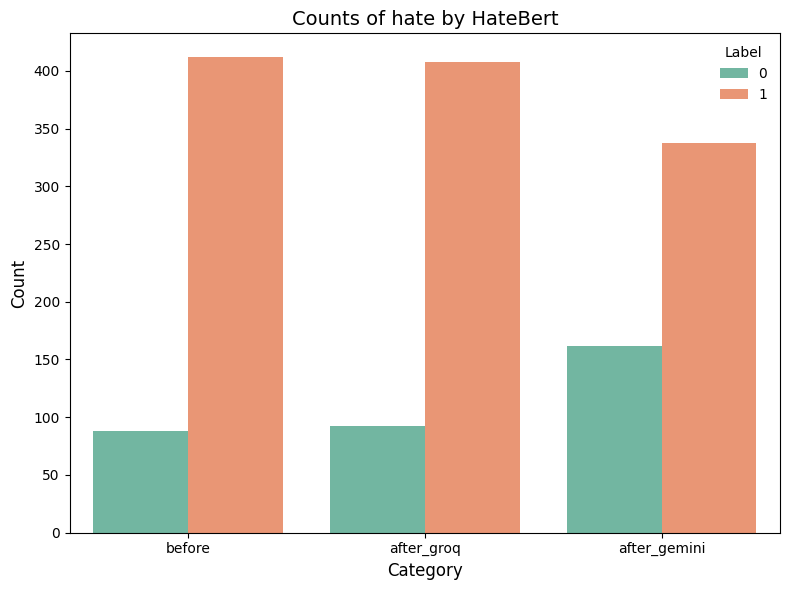

In [93]:

sns.set_palette("Set2")

plt.figure(figsize=(8, 6))  
sns.countplot(data=df_long, x="category", hue="label", dodge=True)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Counts of hate by HateBert", fontsize=14)

plt.legend(title='Label', loc='upper right', frameon=False)

plt.tight_layout()  
plt.show()

In [9]:
df['batch'] = df['batch'] + 1

In [10]:
df_batch_mean = df.groupby("batch").agg(
    groq_success=("groq_transformed", "mean"),
    gemini_success=("gemini_transformed", "mean")
).reset_index()

df_long = df_batch_mean.melt(id_vars="batch", var_name="Model", value_name="Successful Transformations")
df_long


,batch,Model,Successful Transformations
0,1,groq_success,1.00
1,2,groq_success,1.00
2,3,groq_success,1.00
3,4,groq_success,0.95
4,5,groq_success,0.95
5,6,groq_success,1.00
6,7,groq_success,1.00
7,8,groq_success,0.90
8,9,groq_success,1.00
9,10,groq_success,1.00


In [11]:
df_batch_sum = df.groupby("batch").agg(
    groq_success=("groq_transformed", "sum"),
    gemini_success=("gemini_transformed", "sum")
).reset_index()

In [12]:
df_batch_sum.to_csv("../../Dataset/tweets/results/sum_summary.csv", index=False)

In [13]:
df_batch_mean['groq_success'] = (df_batch_mean['groq_success'] * 100).astype(int)
df_batch_mean['gemini_success'] = (df_batch_mean['gemini_success'] * 100).astype(int)


In [14]:
df_batch_mean

,batch,groq_success,gemini_success
0,1,100,100
1,2,100,95
2,3,100,100
3,4,95,100
4,5,95,95
5,6,100,95
6,7,100,100
7,8,90,90
8,9,100,100
9,10,100,95


In [15]:
df_label_sum = df.groupby("labels").agg(
    groq_success=("groq_transformed", "sum"),
    gemini_success=("gemini_transformed", "sum")
).reset_index()
df_label_sum

,labels,groq_success,gemini_success
0,Disciminatory,97,95
1,Misinformation,100,100
2,NSFW,98,96
3,Racism,92,97
4,Religion,98,98


In [16]:
melted_df_label_sum = df_label_sum.melt(id_vars='labels', var_name='model', value_name='transformed')

C:\Users\jiyon\AppData\Local\Temp\ipykernel_26456\2807268737.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.barplot(data=melted_df_label_sum, x='model', y='transformed', hue='labels', palette=palette)


Text(0.5, 1.0, 'Transformation of Groq vs Gemini by abuse label')

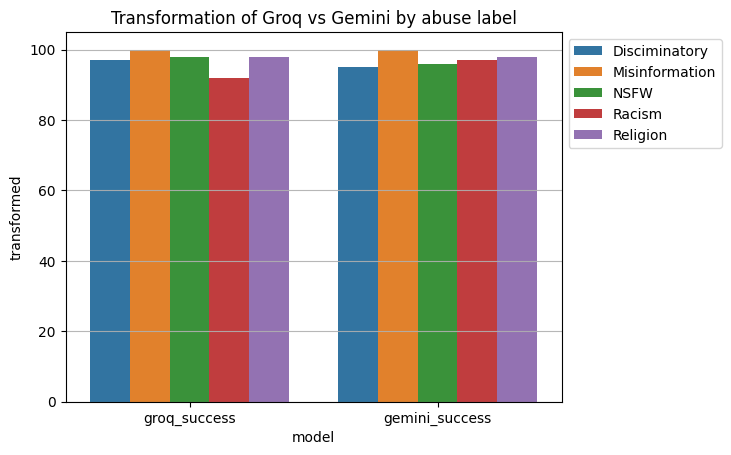

In [17]:
palette = sns.color_palette("tab10")  # set palette
ax = sns.barplot(data=melted_df_label_sum, x='model', y='transformed', hue='labels', palette=palette)
ax.grid(axis='y', linestyle='-', alpha=0.9)  
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title("Transformation of Groq vs Gemini by abuse label")

In [19]:
df['gemini_transformed'].sum()

np.int64(486)

In [14]:
df_batch_mean.to_csv("../../Dataset/tweets/results/mean_summary.csv", index=False)

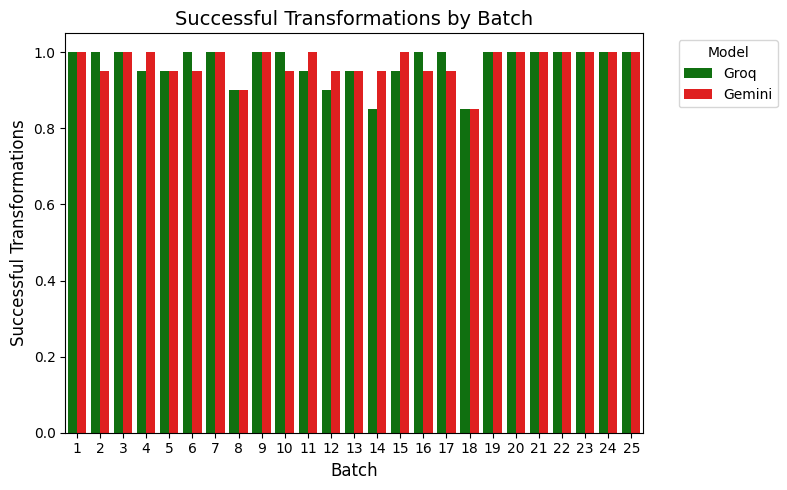

In [15]:
df_long["Model"] = df_long["Model"].replace({"groq_success": "Groq", "gemini_success": "Gemini"})

plt.figure(figsize=(8, 5))
sns.barplot(data=df_long, x="batch", y="Successful Transformations", hue="Model", palette=["green", "red"])

plt.title("Successful Transformations by Batch", fontsize=14)
plt.xlabel("Batch", fontsize=12)
plt.ylabel("Successful Transformations", fontsize=12)

plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)

plt.tight_layout() 
plt.show()